# Barabasi-Albert model (BA)

In [1]:
import networkx as nx
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
from scipy import stats # to do regression for the estimation of the exponent
from scipy.stats import poisson
from network_utils import *
import time

# import cython module for allowinG c compilation and static binding to improve the performance
%load_ext Cython

## Parameters

The algorithm has 3 input parameters: 
* n_0: number of initial nodes
* N: number of final nodes
* m: number of links for each new added node (should be m < m_0)

Insert the parameters of the algorithm

In [2]:
# Insert Parameters
n_0 = int(input("Insert the number of initial nodes:\n"))
N = int(input("\nInsert number of final nodes:\n"))
m = int(input("\nInsert in the value of m parameter:\n"))
if m < 1 or  m >=N:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, N))

Insert the number of initial nodes:
20

Insert number of final nodes:
10000

Insert in the value of m parameter:
5


In [3]:
# name of the model file
model_name = "nets/BA_n020_m5_n10000.net"

Let's now create the initial graph: we build a complete graph with m_0 nodes

In [4]:
G = nx.complete_graph(n_0) # nodes in the range from 0 to m_0

In [5]:
len(G.nodes())

20

In [6]:
# list the nodes
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

We now need to add incrementally nodes until N (we'll add nodes by increasing the number/label identifying each node). 
We use a loop to do that. After adding a node we need to add m links from it to the existing nodes, we'll use another (nested) loop to do that.

## Auxiliary functions
Before implementing the actual code of the algorithm, lets define some helper functions for creating m links between the newly added node and the existing nodes according to the prefential attachment mechanism

The first function we'll define builds the weighted probabilities of the graph nodes. <br>
Since this function is very expensive and it needs to be called at each inserted node during the execution of the BA algorithm, we declare it as a c function and we add also some static binding for some of the used variables. <br>
In this way we greatly improve the performance of the algorithm even when generating networks of big size.

In [7]:
%%cython
import numpy as np
import networkx as nx

# returns the list of the weighted probability of each existing node
def build_probs(G):
    nodes_probs = [] # our list
    
    # static variables
    cdef int node_deg
    cdef double node_prob
    cdef double degrees_sum = 2 * len(G.edges) # N.B.: 2 * len(G.edges) returns the sum of the degrees of all the nodes, since each edge contributes to the degree of 2 nodes
                                     
    # compute the probability for each node
    for node in G.nodes():
        node_deg = G.degree(node)
        
        # probability of the node
        node_prob = node_deg / degrees_sum 
        
        # insert into the list
        nodes_probs.append(node_prob)
    
    return nodes_probs

The 2nd auxiliary function adds m links between a node and the existing nodes, according to the preferential attachment.
We use the random.choice() function of the numpy module, which takes as input the list of nodes among which to select one and the probability associated to each node.

In [8]:
def add_links(G, added_node):
    selected_nodes = [] # list of the selected nodes
    
    # before inserting the links we build the weighted probabilities of each node
    nodes_probs = build_probs(G)
    
    # add m links
    for added_links in range(m):   
        # we use the choice function of the numpy.random module
        selected_node = np.random.choice(G.nodes(),p=nodes_probs) # selects a node according to preferential attachment
        
        # check whether the node was already selected (to avoid multiple links)
        while selected_node in selected_nodes:
            selected_node = np.random.choice(G.nodes(),p=nodes_probs) # select another node
        
        selected_nodes.append(selected_node)
        
        # once we selected the node we should create the link among the added_node given as a parameter
        # and the selected_node
        G.add_edge(added_node, selected_node)
        

## Algorithm

In [9]:
nodes_to_add = N - n_0 # number of nodes to add until reaching N total nodes
inserted_nodes = 0 # counter of the inserted nodes

start_time = time.time()

for n_i in range(nodes_to_add):
     
    # insert new_node in the graph
    print("--------------- STEP: {} ---------------".format(inserted_nodes + 1))
    G.add_node(n_0 + inserted_nodes) # we add the node by specifying its numeric value (starting from 50)
    added_node = n_0 + inserted_nodes # identifier of the added node
    inserted_nodes += 1
    
    print("Node added: {}".format(added_node))
    # add the newly inserted node into nodes_probs because of the random.choice function to work
    
    # --------------------------------------------------------------

    # after adding the node, we need to create m links with the existing nodes 
    # according to the preferential attachment mechanism
    
    # function to add m links to the newly inserted node
    add_links(G, added_node)

elapsed_time = time.time() - start_time

--------------- STEP: 1 ---------------
Node added: 20
--------------- STEP: 2 ---------------
Node added: 21
--------------- STEP: 3 ---------------
Node added: 22
--------------- STEP: 4 ---------------
Node added: 23
--------------- STEP: 5 ---------------
Node added: 24
--------------- STEP: 6 ---------------
Node added: 25
--------------- STEP: 7 ---------------
Node added: 26
--------------- STEP: 8 ---------------
Node added: 27
--------------- STEP: 9 ---------------
Node added: 28
--------------- STEP: 10 ---------------
Node added: 29
--------------- STEP: 11 ---------------
Node added: 30
--------------- STEP: 12 ---------------
Node added: 31
--------------- STEP: 13 ---------------
Node added: 32
--------------- STEP: 14 ---------------
Node added: 33
--------------- STEP: 15 ---------------
Node added: 34
--------------- STEP: 16 ---------------
Node added: 35
--------------- STEP: 17 ---------------
Node added: 36
--------------- STEP: 18 ---------------
Node added: 37
-

--------------- STEP: 313 ---------------
Node added: 332
--------------- STEP: 314 ---------------
Node added: 333
--------------- STEP: 315 ---------------
Node added: 334
--------------- STEP: 316 ---------------
Node added: 335
--------------- STEP: 317 ---------------
Node added: 336
--------------- STEP: 318 ---------------
Node added: 337
--------------- STEP: 319 ---------------
Node added: 338
--------------- STEP: 320 ---------------
Node added: 339
--------------- STEP: 321 ---------------
Node added: 340
--------------- STEP: 322 ---------------
Node added: 341
--------------- STEP: 323 ---------------
Node added: 342
--------------- STEP: 324 ---------------
Node added: 343
--------------- STEP: 325 ---------------
Node added: 344
--------------- STEP: 326 ---------------
Node added: 345
--------------- STEP: 327 ---------------
Node added: 346
--------------- STEP: 328 ---------------
Node added: 347
--------------- STEP: 329 ---------------
Node added: 348
--------------

--------------- STEP: 485 ---------------
Node added: 504
--------------- STEP: 486 ---------------
Node added: 505
--------------- STEP: 487 ---------------
Node added: 506
--------------- STEP: 488 ---------------
Node added: 507
--------------- STEP: 489 ---------------
Node added: 508
--------------- STEP: 490 ---------------
Node added: 509
--------------- STEP: 491 ---------------
Node added: 510
--------------- STEP: 492 ---------------
Node added: 511
--------------- STEP: 493 ---------------
Node added: 512
--------------- STEP: 494 ---------------
Node added: 513
--------------- STEP: 495 ---------------
Node added: 514
--------------- STEP: 496 ---------------
Node added: 515
--------------- STEP: 497 ---------------
Node added: 516
--------------- STEP: 498 ---------------
Node added: 517
--------------- STEP: 499 ---------------
Node added: 518
--------------- STEP: 500 ---------------
Node added: 519
--------------- STEP: 501 ---------------
Node added: 520
--------------

--------------- STEP: 694 ---------------
Node added: 713
--------------- STEP: 695 ---------------
Node added: 714
--------------- STEP: 696 ---------------
Node added: 715
--------------- STEP: 697 ---------------
Node added: 716
--------------- STEP: 698 ---------------
Node added: 717
--------------- STEP: 699 ---------------
Node added: 718
--------------- STEP: 700 ---------------
Node added: 719
--------------- STEP: 701 ---------------
Node added: 720
--------------- STEP: 702 ---------------
Node added: 721
--------------- STEP: 703 ---------------
Node added: 722
--------------- STEP: 704 ---------------
Node added: 723
--------------- STEP: 705 ---------------
Node added: 724
--------------- STEP: 706 ---------------
Node added: 725
--------------- STEP: 707 ---------------
Node added: 726
--------------- STEP: 708 ---------------
Node added: 727
--------------- STEP: 709 ---------------
Node added: 728
--------------- STEP: 710 ---------------
Node added: 729
--------------

--------------- STEP: 869 ---------------
Node added: 888
--------------- STEP: 870 ---------------
Node added: 889
--------------- STEP: 871 ---------------
Node added: 890
--------------- STEP: 872 ---------------
Node added: 891
--------------- STEP: 873 ---------------
Node added: 892
--------------- STEP: 874 ---------------
Node added: 893
--------------- STEP: 875 ---------------
Node added: 894
--------------- STEP: 876 ---------------
Node added: 895
--------------- STEP: 877 ---------------
Node added: 896
--------------- STEP: 878 ---------------
Node added: 897
--------------- STEP: 879 ---------------
Node added: 898
--------------- STEP: 880 ---------------
Node added: 899
--------------- STEP: 881 ---------------
Node added: 900
--------------- STEP: 882 ---------------
Node added: 901
--------------- STEP: 883 ---------------
Node added: 902
--------------- STEP: 884 ---------------
Node added: 903
--------------- STEP: 885 ---------------
Node added: 904
--------------

--------------- STEP: 1033 ---------------
Node added: 1052
--------------- STEP: 1034 ---------------
Node added: 1053
--------------- STEP: 1035 ---------------
Node added: 1054
--------------- STEP: 1036 ---------------
Node added: 1055
--------------- STEP: 1037 ---------------
Node added: 1056
--------------- STEP: 1038 ---------------
Node added: 1057
--------------- STEP: 1039 ---------------
Node added: 1058
--------------- STEP: 1040 ---------------
Node added: 1059
--------------- STEP: 1041 ---------------
Node added: 1060
--------------- STEP: 1042 ---------------
Node added: 1061
--------------- STEP: 1043 ---------------
Node added: 1062
--------------- STEP: 1044 ---------------
Node added: 1063
--------------- STEP: 1045 ---------------
Node added: 1064
--------------- STEP: 1046 ---------------
Node added: 1065
--------------- STEP: 1047 ---------------
Node added: 1066
--------------- STEP: 1048 ---------------
Node added: 1067
--------------- STEP: 1049 -------------

--------------- STEP: 1220 ---------------
Node added: 1239
--------------- STEP: 1221 ---------------
Node added: 1240
--------------- STEP: 1222 ---------------
Node added: 1241
--------------- STEP: 1223 ---------------
Node added: 1242
--------------- STEP: 1224 ---------------
Node added: 1243
--------------- STEP: 1225 ---------------
Node added: 1244
--------------- STEP: 1226 ---------------
Node added: 1245
--------------- STEP: 1227 ---------------
Node added: 1246
--------------- STEP: 1228 ---------------
Node added: 1247
--------------- STEP: 1229 ---------------
Node added: 1248
--------------- STEP: 1230 ---------------
Node added: 1249
--------------- STEP: 1231 ---------------
Node added: 1250
--------------- STEP: 1232 ---------------
Node added: 1251
--------------- STEP: 1233 ---------------
Node added: 1252
--------------- STEP: 1234 ---------------
Node added: 1253
--------------- STEP: 1235 ---------------
Node added: 1254
--------------- STEP: 1236 -------------

--------------- STEP: 1394 ---------------
Node added: 1413
--------------- STEP: 1395 ---------------
Node added: 1414
--------------- STEP: 1396 ---------------
Node added: 1415
--------------- STEP: 1397 ---------------
Node added: 1416
--------------- STEP: 1398 ---------------
Node added: 1417
--------------- STEP: 1399 ---------------
Node added: 1418
--------------- STEP: 1400 ---------------
Node added: 1419
--------------- STEP: 1401 ---------------
Node added: 1420
--------------- STEP: 1402 ---------------
Node added: 1421
--------------- STEP: 1403 ---------------
Node added: 1422
--------------- STEP: 1404 ---------------
Node added: 1423
--------------- STEP: 1405 ---------------
Node added: 1424
--------------- STEP: 1406 ---------------
Node added: 1425
--------------- STEP: 1407 ---------------
Node added: 1426
--------------- STEP: 1408 ---------------
Node added: 1427
--------------- STEP: 1409 ---------------
Node added: 1428
--------------- STEP: 1410 -------------

--------------- STEP: 1559 ---------------
Node added: 1578
--------------- STEP: 1560 ---------------
Node added: 1579
--------------- STEP: 1561 ---------------
Node added: 1580
--------------- STEP: 1562 ---------------
Node added: 1581
--------------- STEP: 1563 ---------------
Node added: 1582
--------------- STEP: 1564 ---------------
Node added: 1583
--------------- STEP: 1565 ---------------
Node added: 1584
--------------- STEP: 1566 ---------------
Node added: 1585
--------------- STEP: 1567 ---------------
Node added: 1586
--------------- STEP: 1568 ---------------
Node added: 1587
--------------- STEP: 1569 ---------------
Node added: 1588
--------------- STEP: 1570 ---------------
Node added: 1589
--------------- STEP: 1571 ---------------
Node added: 1590
--------------- STEP: 1572 ---------------
Node added: 1591
--------------- STEP: 1573 ---------------
Node added: 1592
--------------- STEP: 1574 ---------------
Node added: 1593
--------------- STEP: 1575 -------------

--------------- STEP: 1721 ---------------
Node added: 1740
--------------- STEP: 1722 ---------------
Node added: 1741
--------------- STEP: 1723 ---------------
Node added: 1742
--------------- STEP: 1724 ---------------
Node added: 1743
--------------- STEP: 1725 ---------------
Node added: 1744
--------------- STEP: 1726 ---------------
Node added: 1745
--------------- STEP: 1727 ---------------
Node added: 1746
--------------- STEP: 1728 ---------------
Node added: 1747
--------------- STEP: 1729 ---------------
Node added: 1748
--------------- STEP: 1730 ---------------
Node added: 1749
--------------- STEP: 1731 ---------------
Node added: 1750
--------------- STEP: 1732 ---------------
Node added: 1751
--------------- STEP: 1733 ---------------
Node added: 1752
--------------- STEP: 1734 ---------------
Node added: 1753
--------------- STEP: 1735 ---------------
Node added: 1754
--------------- STEP: 1736 ---------------
Node added: 1755
--------------- STEP: 1737 -------------

--------------- STEP: 1887 ---------------
Node added: 1906
--------------- STEP: 1888 ---------------
Node added: 1907
--------------- STEP: 1889 ---------------
Node added: 1908
--------------- STEP: 1890 ---------------
Node added: 1909
--------------- STEP: 1891 ---------------
Node added: 1910
--------------- STEP: 1892 ---------------
Node added: 1911
--------------- STEP: 1893 ---------------
Node added: 1912
--------------- STEP: 1894 ---------------
Node added: 1913
--------------- STEP: 1895 ---------------
Node added: 1914
--------------- STEP: 1896 ---------------
Node added: 1915
--------------- STEP: 1897 ---------------
Node added: 1916
--------------- STEP: 1898 ---------------
Node added: 1917
--------------- STEP: 1899 ---------------
Node added: 1918
--------------- STEP: 1900 ---------------
Node added: 1919
--------------- STEP: 1901 ---------------
Node added: 1920
--------------- STEP: 1902 ---------------
Node added: 1921
--------------- STEP: 1903 -------------

--------------- STEP: 2023 ---------------
Node added: 2042
--------------- STEP: 2024 ---------------
Node added: 2043
--------------- STEP: 2025 ---------------
Node added: 2044
--------------- STEP: 2026 ---------------
Node added: 2045
--------------- STEP: 2027 ---------------
Node added: 2046
--------------- STEP: 2028 ---------------
Node added: 2047
--------------- STEP: 2029 ---------------
Node added: 2048
--------------- STEP: 2030 ---------------
Node added: 2049
--------------- STEP: 2031 ---------------
Node added: 2050
--------------- STEP: 2032 ---------------
Node added: 2051
--------------- STEP: 2033 ---------------
Node added: 2052
--------------- STEP: 2034 ---------------
Node added: 2053
--------------- STEP: 2035 ---------------
Node added: 2054
--------------- STEP: 2036 ---------------
Node added: 2055
--------------- STEP: 2037 ---------------
Node added: 2056
--------------- STEP: 2038 ---------------
Node added: 2057
--------------- STEP: 2039 -------------

--------------- STEP: 2199 ---------------
Node added: 2218
--------------- STEP: 2200 ---------------
Node added: 2219
--------------- STEP: 2201 ---------------
Node added: 2220
--------------- STEP: 2202 ---------------
Node added: 2221
--------------- STEP: 2203 ---------------
Node added: 2222
--------------- STEP: 2204 ---------------
Node added: 2223
--------------- STEP: 2205 ---------------
Node added: 2224
--------------- STEP: 2206 ---------------
Node added: 2225
--------------- STEP: 2207 ---------------
Node added: 2226
--------------- STEP: 2208 ---------------
Node added: 2227
--------------- STEP: 2209 ---------------
Node added: 2228
--------------- STEP: 2210 ---------------
Node added: 2229
--------------- STEP: 2211 ---------------
Node added: 2230
--------------- STEP: 2212 ---------------
Node added: 2231
--------------- STEP: 2213 ---------------
Node added: 2232
--------------- STEP: 2214 ---------------
Node added: 2233
--------------- STEP: 2215 -------------

--------------- STEP: 2352 ---------------
Node added: 2371
--------------- STEP: 2353 ---------------
Node added: 2372
--------------- STEP: 2354 ---------------
Node added: 2373
--------------- STEP: 2355 ---------------
Node added: 2374
--------------- STEP: 2356 ---------------
Node added: 2375
--------------- STEP: 2357 ---------------
Node added: 2376
--------------- STEP: 2358 ---------------
Node added: 2377
--------------- STEP: 2359 ---------------
Node added: 2378
--------------- STEP: 2360 ---------------
Node added: 2379
--------------- STEP: 2361 ---------------
Node added: 2380
--------------- STEP: 2362 ---------------
Node added: 2381
--------------- STEP: 2363 ---------------
Node added: 2382
--------------- STEP: 2364 ---------------
Node added: 2383
--------------- STEP: 2365 ---------------
Node added: 2384
--------------- STEP: 2366 ---------------
Node added: 2385
--------------- STEP: 2367 ---------------
Node added: 2386
--------------- STEP: 2368 -------------

--------------- STEP: 2511 ---------------
Node added: 2530
--------------- STEP: 2512 ---------------
Node added: 2531
--------------- STEP: 2513 ---------------
Node added: 2532
--------------- STEP: 2514 ---------------
Node added: 2533
--------------- STEP: 2515 ---------------
Node added: 2534
--------------- STEP: 2516 ---------------
Node added: 2535
--------------- STEP: 2517 ---------------
Node added: 2536
--------------- STEP: 2518 ---------------
Node added: 2537
--------------- STEP: 2519 ---------------
Node added: 2538
--------------- STEP: 2520 ---------------
Node added: 2539
--------------- STEP: 2521 ---------------
Node added: 2540
--------------- STEP: 2522 ---------------
Node added: 2541
--------------- STEP: 2523 ---------------
Node added: 2542
--------------- STEP: 2524 ---------------
Node added: 2543
--------------- STEP: 2525 ---------------
Node added: 2544
--------------- STEP: 2526 ---------------
Node added: 2545
--------------- STEP: 2527 -------------

--------------- STEP: 2677 ---------------
Node added: 2696
--------------- STEP: 2678 ---------------
Node added: 2697
--------------- STEP: 2679 ---------------
Node added: 2698
--------------- STEP: 2680 ---------------
Node added: 2699
--------------- STEP: 2681 ---------------
Node added: 2700
--------------- STEP: 2682 ---------------
Node added: 2701
--------------- STEP: 2683 ---------------
Node added: 2702
--------------- STEP: 2684 ---------------
Node added: 2703
--------------- STEP: 2685 ---------------
Node added: 2704
--------------- STEP: 2686 ---------------
Node added: 2705
--------------- STEP: 2687 ---------------
Node added: 2706
--------------- STEP: 2688 ---------------
Node added: 2707
--------------- STEP: 2689 ---------------
Node added: 2708
--------------- STEP: 2690 ---------------
Node added: 2709
--------------- STEP: 2691 ---------------
Node added: 2710
--------------- STEP: 2692 ---------------
Node added: 2711
--------------- STEP: 2693 -------------

--------------- STEP: 2817 ---------------
Node added: 2836
--------------- STEP: 2818 ---------------
Node added: 2837
--------------- STEP: 2819 ---------------
Node added: 2838
--------------- STEP: 2820 ---------------
Node added: 2839
--------------- STEP: 2821 ---------------
Node added: 2840
--------------- STEP: 2822 ---------------
Node added: 2841
--------------- STEP: 2823 ---------------
Node added: 2842
--------------- STEP: 2824 ---------------
Node added: 2843
--------------- STEP: 2825 ---------------
Node added: 2844
--------------- STEP: 2826 ---------------
Node added: 2845
--------------- STEP: 2827 ---------------
Node added: 2846
--------------- STEP: 2828 ---------------
Node added: 2847
--------------- STEP: 2829 ---------------
Node added: 2848
--------------- STEP: 2830 ---------------
Node added: 2849
--------------- STEP: 2831 ---------------
Node added: 2850
--------------- STEP: 2832 ---------------
Node added: 2851
--------------- STEP: 2833 -------------

--------------- STEP: 2985 ---------------
Node added: 3004
--------------- STEP: 2986 ---------------
Node added: 3005
--------------- STEP: 2987 ---------------
Node added: 3006
--------------- STEP: 2988 ---------------
Node added: 3007
--------------- STEP: 2989 ---------------
Node added: 3008
--------------- STEP: 2990 ---------------
Node added: 3009
--------------- STEP: 2991 ---------------
Node added: 3010
--------------- STEP: 2992 ---------------
Node added: 3011
--------------- STEP: 2993 ---------------
Node added: 3012
--------------- STEP: 2994 ---------------
Node added: 3013
--------------- STEP: 2995 ---------------
Node added: 3014
--------------- STEP: 2996 ---------------
Node added: 3015
--------------- STEP: 2997 ---------------
Node added: 3016
--------------- STEP: 2998 ---------------
Node added: 3017
--------------- STEP: 2999 ---------------
Node added: 3018
--------------- STEP: 3000 ---------------
Node added: 3019
--------------- STEP: 3001 -------------

--------------- STEP: 3137 ---------------
Node added: 3156
--------------- STEP: 3138 ---------------
Node added: 3157
--------------- STEP: 3139 ---------------
Node added: 3158
--------------- STEP: 3140 ---------------
Node added: 3159
--------------- STEP: 3141 ---------------
Node added: 3160
--------------- STEP: 3142 ---------------
Node added: 3161
--------------- STEP: 3143 ---------------
Node added: 3162
--------------- STEP: 3144 ---------------
Node added: 3163
--------------- STEP: 3145 ---------------
Node added: 3164
--------------- STEP: 3146 ---------------
Node added: 3165
--------------- STEP: 3147 ---------------
Node added: 3166
--------------- STEP: 3148 ---------------
Node added: 3167
--------------- STEP: 3149 ---------------
Node added: 3168
--------------- STEP: 3150 ---------------
Node added: 3169
--------------- STEP: 3151 ---------------
Node added: 3170
--------------- STEP: 3152 ---------------
Node added: 3171
--------------- STEP: 3153 -------------

--------------- STEP: 3274 ---------------
Node added: 3293
--------------- STEP: 3275 ---------------
Node added: 3294
--------------- STEP: 3276 ---------------
Node added: 3295
--------------- STEP: 3277 ---------------
Node added: 3296
--------------- STEP: 3278 ---------------
Node added: 3297
--------------- STEP: 3279 ---------------
Node added: 3298
--------------- STEP: 3280 ---------------
Node added: 3299
--------------- STEP: 3281 ---------------
Node added: 3300
--------------- STEP: 3282 ---------------
Node added: 3301
--------------- STEP: 3283 ---------------
Node added: 3302
--------------- STEP: 3284 ---------------
Node added: 3303
--------------- STEP: 3285 ---------------
Node added: 3304
--------------- STEP: 3286 ---------------
Node added: 3305
--------------- STEP: 3287 ---------------
Node added: 3306
--------------- STEP: 3288 ---------------
Node added: 3307
--------------- STEP: 3289 ---------------
Node added: 3308
--------------- STEP: 3290 -------------

--------------- STEP: 3418 ---------------
Node added: 3437
--------------- STEP: 3419 ---------------
Node added: 3438
--------------- STEP: 3420 ---------------
Node added: 3439
--------------- STEP: 3421 ---------------
Node added: 3440
--------------- STEP: 3422 ---------------
Node added: 3441
--------------- STEP: 3423 ---------------
Node added: 3442
--------------- STEP: 3424 ---------------
Node added: 3443
--------------- STEP: 3425 ---------------
Node added: 3444
--------------- STEP: 3426 ---------------
Node added: 3445
--------------- STEP: 3427 ---------------
Node added: 3446
--------------- STEP: 3428 ---------------
Node added: 3447
--------------- STEP: 3429 ---------------
Node added: 3448
--------------- STEP: 3430 ---------------
Node added: 3449
--------------- STEP: 3431 ---------------
Node added: 3450
--------------- STEP: 3432 ---------------
Node added: 3451
--------------- STEP: 3433 ---------------
Node added: 3452
--------------- STEP: 3434 -------------

--------------- STEP: 3567 ---------------
Node added: 3586
--------------- STEP: 3568 ---------------
Node added: 3587
--------------- STEP: 3569 ---------------
Node added: 3588
--------------- STEP: 3570 ---------------
Node added: 3589
--------------- STEP: 3571 ---------------
Node added: 3590
--------------- STEP: 3572 ---------------
Node added: 3591
--------------- STEP: 3573 ---------------
Node added: 3592
--------------- STEP: 3574 ---------------
Node added: 3593
--------------- STEP: 3575 ---------------
Node added: 3594
--------------- STEP: 3576 ---------------
Node added: 3595
--------------- STEP: 3577 ---------------
Node added: 3596
--------------- STEP: 3578 ---------------
Node added: 3597
--------------- STEP: 3579 ---------------
Node added: 3598
--------------- STEP: 3580 ---------------
Node added: 3599
--------------- STEP: 3581 ---------------
Node added: 3600
--------------- STEP: 3582 ---------------
Node added: 3601
--------------- STEP: 3583 -------------

--------------- STEP: 3726 ---------------
Node added: 3745
--------------- STEP: 3727 ---------------
Node added: 3746
--------------- STEP: 3728 ---------------
Node added: 3747
--------------- STEP: 3729 ---------------
Node added: 3748
--------------- STEP: 3730 ---------------
Node added: 3749
--------------- STEP: 3731 ---------------
Node added: 3750
--------------- STEP: 3732 ---------------
Node added: 3751
--------------- STEP: 3733 ---------------
Node added: 3752
--------------- STEP: 3734 ---------------
Node added: 3753
--------------- STEP: 3735 ---------------
Node added: 3754
--------------- STEP: 3736 ---------------
Node added: 3755
--------------- STEP: 3737 ---------------
Node added: 3756
--------------- STEP: 3738 ---------------
Node added: 3757
--------------- STEP: 3739 ---------------
Node added: 3758
--------------- STEP: 3740 ---------------
Node added: 3759
--------------- STEP: 3741 ---------------
Node added: 3760
--------------- STEP: 3742 -------------

Node added: 3908
--------------- STEP: 3890 ---------------
Node added: 3909
--------------- STEP: 3891 ---------------
Node added: 3910
--------------- STEP: 3892 ---------------
Node added: 3911
--------------- STEP: 3893 ---------------
Node added: 3912
--------------- STEP: 3894 ---------------
Node added: 3913
--------------- STEP: 3895 ---------------
Node added: 3914
--------------- STEP: 3896 ---------------
Node added: 3915
--------------- STEP: 3897 ---------------
Node added: 3916
--------------- STEP: 3898 ---------------
Node added: 3917
--------------- STEP: 3899 ---------------
Node added: 3918
--------------- STEP: 3900 ---------------
Node added: 3919
--------------- STEP: 3901 ---------------
Node added: 3920
--------------- STEP: 3902 ---------------
Node added: 3921
--------------- STEP: 3903 ---------------
Node added: 3922
--------------- STEP: 3904 ---------------
Node added: 3923
--------------- STEP: 3905 ---------------
Node added: 3924
--------------- STEP: 3

--------------- STEP: 4050 ---------------
Node added: 4069
--------------- STEP: 4051 ---------------
Node added: 4070
--------------- STEP: 4052 ---------------
Node added: 4071
--------------- STEP: 4053 ---------------
Node added: 4072
--------------- STEP: 4054 ---------------
Node added: 4073
--------------- STEP: 4055 ---------------
Node added: 4074
--------------- STEP: 4056 ---------------
Node added: 4075
--------------- STEP: 4057 ---------------
Node added: 4076
--------------- STEP: 4058 ---------------
Node added: 4077
--------------- STEP: 4059 ---------------
Node added: 4078
--------------- STEP: 4060 ---------------
Node added: 4079
--------------- STEP: 4061 ---------------
Node added: 4080
--------------- STEP: 4062 ---------------
Node added: 4081
--------------- STEP: 4063 ---------------
Node added: 4082
--------------- STEP: 4064 ---------------
Node added: 4083
--------------- STEP: 4065 ---------------
Node added: 4084
--------------- STEP: 4066 -------------

--------------- STEP: 4206 ---------------
Node added: 4225
--------------- STEP: 4207 ---------------
Node added: 4226
--------------- STEP: 4208 ---------------
Node added: 4227
--------------- STEP: 4209 ---------------
Node added: 4228
--------------- STEP: 4210 ---------------
Node added: 4229
--------------- STEP: 4211 ---------------
Node added: 4230
--------------- STEP: 4212 ---------------
Node added: 4231
--------------- STEP: 4213 ---------------
Node added: 4232
--------------- STEP: 4214 ---------------
Node added: 4233
--------------- STEP: 4215 ---------------
Node added: 4234
--------------- STEP: 4216 ---------------
Node added: 4235
--------------- STEP: 4217 ---------------
Node added: 4236
--------------- STEP: 4218 ---------------
Node added: 4237
--------------- STEP: 4219 ---------------
Node added: 4238
--------------- STEP: 4220 ---------------
Node added: 4239
--------------- STEP: 4221 ---------------
Node added: 4240
--------------- STEP: 4222 -------------

--------------- STEP: 4351 ---------------
Node added: 4370
--------------- STEP: 4352 ---------------
Node added: 4371
--------------- STEP: 4353 ---------------
Node added: 4372
--------------- STEP: 4354 ---------------
Node added: 4373
--------------- STEP: 4355 ---------------
Node added: 4374
--------------- STEP: 4356 ---------------
Node added: 4375
--------------- STEP: 4357 ---------------
Node added: 4376
--------------- STEP: 4358 ---------------
Node added: 4377
--------------- STEP: 4359 ---------------
Node added: 4378
--------------- STEP: 4360 ---------------
Node added: 4379
--------------- STEP: 4361 ---------------
Node added: 4380
--------------- STEP: 4362 ---------------
Node added: 4381
--------------- STEP: 4363 ---------------
Node added: 4382
--------------- STEP: 4364 ---------------
Node added: 4383
--------------- STEP: 4365 ---------------
Node added: 4384
--------------- STEP: 4366 ---------------
Node added: 4385
--------------- STEP: 4367 -------------

--------------- STEP: 4491 ---------------
Node added: 4510
--------------- STEP: 4492 ---------------
Node added: 4511
--------------- STEP: 4493 ---------------
Node added: 4512
--------------- STEP: 4494 ---------------
Node added: 4513
--------------- STEP: 4495 ---------------
Node added: 4514
--------------- STEP: 4496 ---------------
Node added: 4515
--------------- STEP: 4497 ---------------
Node added: 4516
--------------- STEP: 4498 ---------------
Node added: 4517
--------------- STEP: 4499 ---------------
Node added: 4518
--------------- STEP: 4500 ---------------
Node added: 4519
--------------- STEP: 4501 ---------------
Node added: 4520
--------------- STEP: 4502 ---------------
Node added: 4521
--------------- STEP: 4503 ---------------
Node added: 4522
--------------- STEP: 4504 ---------------
Node added: 4523
--------------- STEP: 4505 ---------------
Node added: 4524
--------------- STEP: 4506 ---------------
Node added: 4525
--------------- STEP: 4507 -------------

--------------- STEP: 4638 ---------------
Node added: 4657
--------------- STEP: 4639 ---------------
Node added: 4658
--------------- STEP: 4640 ---------------
Node added: 4659
--------------- STEP: 4641 ---------------
Node added: 4660
--------------- STEP: 4642 ---------------
Node added: 4661
--------------- STEP: 4643 ---------------
Node added: 4662
--------------- STEP: 4644 ---------------
Node added: 4663
--------------- STEP: 4645 ---------------
Node added: 4664
--------------- STEP: 4646 ---------------
Node added: 4665
--------------- STEP: 4647 ---------------
Node added: 4666
--------------- STEP: 4648 ---------------
Node added: 4667
--------------- STEP: 4649 ---------------
Node added: 4668
--------------- STEP: 4650 ---------------
Node added: 4669
--------------- STEP: 4651 ---------------
Node added: 4670
--------------- STEP: 4652 ---------------
Node added: 4671
--------------- STEP: 4653 ---------------
Node added: 4672
--------------- STEP: 4654 -------------

--------------- STEP: 4775 ---------------
Node added: 4794
--------------- STEP: 4776 ---------------
Node added: 4795
--------------- STEP: 4777 ---------------
Node added: 4796
--------------- STEP: 4778 ---------------
Node added: 4797
--------------- STEP: 4779 ---------------
Node added: 4798
--------------- STEP: 4780 ---------------
Node added: 4799
--------------- STEP: 4781 ---------------
Node added: 4800
--------------- STEP: 4782 ---------------
Node added: 4801
--------------- STEP: 4783 ---------------
Node added: 4802
--------------- STEP: 4784 ---------------
Node added: 4803
--------------- STEP: 4785 ---------------
Node added: 4804
--------------- STEP: 4786 ---------------
Node added: 4805
--------------- STEP: 4787 ---------------
Node added: 4806
--------------- STEP: 4788 ---------------
Node added: 4807
--------------- STEP: 4789 ---------------
Node added: 4808
--------------- STEP: 4790 ---------------
Node added: 4809
--------------- STEP: 4791 -------------

--------------- STEP: 4916 ---------------
Node added: 4935
--------------- STEP: 4917 ---------------
Node added: 4936
--------------- STEP: 4918 ---------------
Node added: 4937
--------------- STEP: 4919 ---------------
Node added: 4938
--------------- STEP: 4920 ---------------
Node added: 4939
--------------- STEP: 4921 ---------------
Node added: 4940
--------------- STEP: 4922 ---------------
Node added: 4941
--------------- STEP: 4923 ---------------
Node added: 4942
--------------- STEP: 4924 ---------------
Node added: 4943
--------------- STEP: 4925 ---------------
Node added: 4944
--------------- STEP: 4926 ---------------
Node added: 4945
--------------- STEP: 4927 ---------------
Node added: 4946
--------------- STEP: 4928 ---------------
Node added: 4947
--------------- STEP: 4929 ---------------
Node added: 4948
--------------- STEP: 4930 ---------------
Node added: 4949
--------------- STEP: 4931 ---------------
Node added: 4950
--------------- STEP: 4932 -------------

--------------- STEP: 5067 ---------------
Node added: 5086
--------------- STEP: 5068 ---------------
Node added: 5087
--------------- STEP: 5069 ---------------
Node added: 5088
--------------- STEP: 5070 ---------------
Node added: 5089
--------------- STEP: 5071 ---------------
Node added: 5090
--------------- STEP: 5072 ---------------
Node added: 5091
--------------- STEP: 5073 ---------------
Node added: 5092
--------------- STEP: 5074 ---------------
Node added: 5093
--------------- STEP: 5075 ---------------
Node added: 5094
--------------- STEP: 5076 ---------------
Node added: 5095
--------------- STEP: 5077 ---------------
Node added: 5096
--------------- STEP: 5078 ---------------
Node added: 5097
--------------- STEP: 5079 ---------------
Node added: 5098
--------------- STEP: 5080 ---------------
Node added: 5099
--------------- STEP: 5081 ---------------
Node added: 5100
--------------- STEP: 5082 ---------------
Node added: 5101
--------------- STEP: 5083 -------------

--------------- STEP: 5206 ---------------
Node added: 5225
--------------- STEP: 5207 ---------------
Node added: 5226
--------------- STEP: 5208 ---------------
Node added: 5227
--------------- STEP: 5209 ---------------
Node added: 5228
--------------- STEP: 5210 ---------------
Node added: 5229
--------------- STEP: 5211 ---------------
Node added: 5230
--------------- STEP: 5212 ---------------
Node added: 5231
--------------- STEP: 5213 ---------------
Node added: 5232
--------------- STEP: 5214 ---------------
Node added: 5233
--------------- STEP: 5215 ---------------
Node added: 5234
--------------- STEP: 5216 ---------------
Node added: 5235
--------------- STEP: 5217 ---------------
Node added: 5236
--------------- STEP: 5218 ---------------
Node added: 5237
--------------- STEP: 5219 ---------------
Node added: 5238
--------------- STEP: 5220 ---------------
Node added: 5239
--------------- STEP: 5221 ---------------
Node added: 5240
--------------- STEP: 5222 -------------

--------------- STEP: 5358 ---------------
Node added: 5377
--------------- STEP: 5359 ---------------
Node added: 5378
--------------- STEP: 5360 ---------------
Node added: 5379
--------------- STEP: 5361 ---------------
Node added: 5380
--------------- STEP: 5362 ---------------
Node added: 5381
--------------- STEP: 5363 ---------------
Node added: 5382
--------------- STEP: 5364 ---------------
Node added: 5383
--------------- STEP: 5365 ---------------
Node added: 5384
--------------- STEP: 5366 ---------------
Node added: 5385
--------------- STEP: 5367 ---------------
Node added: 5386
--------------- STEP: 5368 ---------------
Node added: 5387
--------------- STEP: 5369 ---------------
Node added: 5388
--------------- STEP: 5370 ---------------
Node added: 5389
--------------- STEP: 5371 ---------------
Node added: 5390
--------------- STEP: 5372 ---------------
Node added: 5391
--------------- STEP: 5373 ---------------
Node added: 5392
--------------- STEP: 5374 -------------

--------------- STEP: 5500 ---------------
Node added: 5519
--------------- STEP: 5501 ---------------
Node added: 5520
--------------- STEP: 5502 ---------------
Node added: 5521
--------------- STEP: 5503 ---------------
Node added: 5522
--------------- STEP: 5504 ---------------
Node added: 5523
--------------- STEP: 5505 ---------------
Node added: 5524
--------------- STEP: 5506 ---------------
Node added: 5525
--------------- STEP: 5507 ---------------
Node added: 5526
--------------- STEP: 5508 ---------------
Node added: 5527
--------------- STEP: 5509 ---------------
Node added: 5528
--------------- STEP: 5510 ---------------
Node added: 5529
--------------- STEP: 5511 ---------------
Node added: 5530
--------------- STEP: 5512 ---------------
Node added: 5531
--------------- STEP: 5513 ---------------
Node added: 5532
--------------- STEP: 5514 ---------------
Node added: 5533
--------------- STEP: 5515 ---------------
Node added: 5534
--------------- STEP: 5516 -------------

--------------- STEP: 5643 ---------------
Node added: 5662
--------------- STEP: 5644 ---------------
Node added: 5663
--------------- STEP: 5645 ---------------
Node added: 5664
--------------- STEP: 5646 ---------------
Node added: 5665
--------------- STEP: 5647 ---------------
Node added: 5666
--------------- STEP: 5648 ---------------
Node added: 5667
--------------- STEP: 5649 ---------------
Node added: 5668
--------------- STEP: 5650 ---------------
Node added: 5669
--------------- STEP: 5651 ---------------
Node added: 5670
--------------- STEP: 5652 ---------------
Node added: 5671
--------------- STEP: 5653 ---------------
Node added: 5672
--------------- STEP: 5654 ---------------
Node added: 5673
--------------- STEP: 5655 ---------------
Node added: 5674
--------------- STEP: 5656 ---------------
Node added: 5675
--------------- STEP: 5657 ---------------
Node added: 5676
--------------- STEP: 5658 ---------------
Node added: 5677
--------------- STEP: 5659 -------------

--------------- STEP: 5792 ---------------
Node added: 5811
--------------- STEP: 5793 ---------------
Node added: 5812
--------------- STEP: 5794 ---------------
Node added: 5813
--------------- STEP: 5795 ---------------
Node added: 5814
--------------- STEP: 5796 ---------------
Node added: 5815
--------------- STEP: 5797 ---------------
Node added: 5816
--------------- STEP: 5798 ---------------
Node added: 5817
--------------- STEP: 5799 ---------------
Node added: 5818
--------------- STEP: 5800 ---------------
Node added: 5819
--------------- STEP: 5801 ---------------
Node added: 5820
--------------- STEP: 5802 ---------------
Node added: 5821
--------------- STEP: 5803 ---------------
Node added: 5822
--------------- STEP: 5804 ---------------
Node added: 5823
--------------- STEP: 5805 ---------------
Node added: 5824
--------------- STEP: 5806 ---------------
Node added: 5825
--------------- STEP: 5807 ---------------
Node added: 5826
--------------- STEP: 5808 -------------

--------------- STEP: 5944 ---------------
Node added: 5963
--------------- STEP: 5945 ---------------
Node added: 5964
--------------- STEP: 5946 ---------------
Node added: 5965
--------------- STEP: 5947 ---------------
Node added: 5966
--------------- STEP: 5948 ---------------
Node added: 5967
--------------- STEP: 5949 ---------------
Node added: 5968
--------------- STEP: 5950 ---------------
Node added: 5969
--------------- STEP: 5951 ---------------
Node added: 5970
--------------- STEP: 5952 ---------------
Node added: 5971
--------------- STEP: 5953 ---------------
Node added: 5972
--------------- STEP: 5954 ---------------
Node added: 5973
--------------- STEP: 5955 ---------------
Node added: 5974
--------------- STEP: 5956 ---------------
Node added: 5975
--------------- STEP: 5957 ---------------
Node added: 5976
--------------- STEP: 5958 ---------------
Node added: 5977
--------------- STEP: 5959 ---------------
Node added: 5978
--------------- STEP: 5960 -------------

--------------- STEP: 6089 ---------------
Node added: 6108
--------------- STEP: 6090 ---------------
Node added: 6109
--------------- STEP: 6091 ---------------
Node added: 6110
--------------- STEP: 6092 ---------------
Node added: 6111
--------------- STEP: 6093 ---------------
Node added: 6112
--------------- STEP: 6094 ---------------
Node added: 6113
--------------- STEP: 6095 ---------------
Node added: 6114
--------------- STEP: 6096 ---------------
Node added: 6115
--------------- STEP: 6097 ---------------
Node added: 6116
--------------- STEP: 6098 ---------------
Node added: 6117
--------------- STEP: 6099 ---------------
Node added: 6118
--------------- STEP: 6100 ---------------
Node added: 6119
--------------- STEP: 6101 ---------------
Node added: 6120
--------------- STEP: 6102 ---------------
Node added: 6121
--------------- STEP: 6103 ---------------
Node added: 6122
--------------- STEP: 6104 ---------------
Node added: 6123
--------------- STEP: 6105 -------------

--------------- STEP: 6244 ---------------
Node added: 6263
--------------- STEP: 6245 ---------------
Node added: 6264
--------------- STEP: 6246 ---------------
Node added: 6265
--------------- STEP: 6247 ---------------
Node added: 6266
--------------- STEP: 6248 ---------------
Node added: 6267
--------------- STEP: 6249 ---------------
Node added: 6268
--------------- STEP: 6250 ---------------
Node added: 6269
--------------- STEP: 6251 ---------------
Node added: 6270
--------------- STEP: 6252 ---------------
Node added: 6271
--------------- STEP: 6253 ---------------
Node added: 6272
--------------- STEP: 6254 ---------------
Node added: 6273
--------------- STEP: 6255 ---------------
Node added: 6274
--------------- STEP: 6256 ---------------
Node added: 6275
--------------- STEP: 6257 ---------------
Node added: 6276
--------------- STEP: 6258 ---------------
Node added: 6277
--------------- STEP: 6259 ---------------
Node added: 6278
--------------- STEP: 6260 -------------

--------------- STEP: 6385 ---------------
Node added: 6404
--------------- STEP: 6386 ---------------
Node added: 6405
--------------- STEP: 6387 ---------------
Node added: 6406
--------------- STEP: 6388 ---------------
Node added: 6407
--------------- STEP: 6389 ---------------
Node added: 6408
--------------- STEP: 6390 ---------------
Node added: 6409
--------------- STEP: 6391 ---------------
Node added: 6410
--------------- STEP: 6392 ---------------
Node added: 6411
--------------- STEP: 6393 ---------------
Node added: 6412
--------------- STEP: 6394 ---------------
Node added: 6413
--------------- STEP: 6395 ---------------
Node added: 6414
--------------- STEP: 6396 ---------------
Node added: 6415
--------------- STEP: 6397 ---------------
Node added: 6416
--------------- STEP: 6398 ---------------
Node added: 6417
--------------- STEP: 6399 ---------------
Node added: 6418
--------------- STEP: 6400 ---------------
Node added: 6419
--------------- STEP: 6401 -------------

--------------- STEP: 6532 ---------------
Node added: 6551
--------------- STEP: 6533 ---------------
Node added: 6552
--------------- STEP: 6534 ---------------
Node added: 6553
--------------- STEP: 6535 ---------------
Node added: 6554
--------------- STEP: 6536 ---------------
Node added: 6555
--------------- STEP: 6537 ---------------
Node added: 6556
--------------- STEP: 6538 ---------------
Node added: 6557
--------------- STEP: 6539 ---------------
Node added: 6558
--------------- STEP: 6540 ---------------
Node added: 6559
--------------- STEP: 6541 ---------------
Node added: 6560
--------------- STEP: 6542 ---------------
Node added: 6561
--------------- STEP: 6543 ---------------
Node added: 6562
--------------- STEP: 6544 ---------------
Node added: 6563
--------------- STEP: 6545 ---------------
Node added: 6564
--------------- STEP: 6546 ---------------
Node added: 6565
--------------- STEP: 6547 ---------------
Node added: 6566
--------------- STEP: 6548 -------------

--------------- STEP: 6676 ---------------
Node added: 6695
--------------- STEP: 6677 ---------------
Node added: 6696
--------------- STEP: 6678 ---------------
Node added: 6697
--------------- STEP: 6679 ---------------
Node added: 6698
--------------- STEP: 6680 ---------------
Node added: 6699
--------------- STEP: 6681 ---------------
Node added: 6700
--------------- STEP: 6682 ---------------
Node added: 6701
--------------- STEP: 6683 ---------------
Node added: 6702
--------------- STEP: 6684 ---------------
Node added: 6703
--------------- STEP: 6685 ---------------
Node added: 6704
--------------- STEP: 6686 ---------------
Node added: 6705
--------------- STEP: 6687 ---------------
Node added: 6706
--------------- STEP: 6688 ---------------
Node added: 6707
--------------- STEP: 6689 ---------------
Node added: 6708
--------------- STEP: 6690 ---------------
Node added: 6709
--------------- STEP: 6691 ---------------
Node added: 6710
--------------- STEP: 6692 -------------

--------------- STEP: 6826 ---------------
Node added: 6845
--------------- STEP: 6827 ---------------
Node added: 6846
--------------- STEP: 6828 ---------------
Node added: 6847
--------------- STEP: 6829 ---------------
Node added: 6848
--------------- STEP: 6830 ---------------
Node added: 6849
--------------- STEP: 6831 ---------------
Node added: 6850
--------------- STEP: 6832 ---------------
Node added: 6851
--------------- STEP: 6833 ---------------
Node added: 6852
--------------- STEP: 6834 ---------------
Node added: 6853
--------------- STEP: 6835 ---------------
Node added: 6854
--------------- STEP: 6836 ---------------
Node added: 6855
--------------- STEP: 6837 ---------------
Node added: 6856
--------------- STEP: 6838 ---------------
Node added: 6857
--------------- STEP: 6839 ---------------
Node added: 6858
--------------- STEP: 6840 ---------------
Node added: 6859
--------------- STEP: 6841 ---------------
Node added: 6860
--------------- STEP: 6842 -------------

--------------- STEP: 6970 ---------------
Node added: 6989
--------------- STEP: 6971 ---------------
Node added: 6990
--------------- STEP: 6972 ---------------
Node added: 6991
--------------- STEP: 6973 ---------------
Node added: 6992
--------------- STEP: 6974 ---------------
Node added: 6993
--------------- STEP: 6975 ---------------
Node added: 6994
--------------- STEP: 6976 ---------------
Node added: 6995
--------------- STEP: 6977 ---------------
Node added: 6996
--------------- STEP: 6978 ---------------
Node added: 6997
--------------- STEP: 6979 ---------------
Node added: 6998
--------------- STEP: 6980 ---------------
Node added: 6999
--------------- STEP: 6981 ---------------
Node added: 7000
--------------- STEP: 6982 ---------------
Node added: 7001
--------------- STEP: 6983 ---------------
Node added: 7002
--------------- STEP: 6984 ---------------
Node added: 7003
--------------- STEP: 6985 ---------------
Node added: 7004
--------------- STEP: 6986 -------------

--------------- STEP: 7115 ---------------
Node added: 7134
--------------- STEP: 7116 ---------------
Node added: 7135
--------------- STEP: 7117 ---------------
Node added: 7136
--------------- STEP: 7118 ---------------
Node added: 7137
--------------- STEP: 7119 ---------------
Node added: 7138
--------------- STEP: 7120 ---------------
Node added: 7139
--------------- STEP: 7121 ---------------
Node added: 7140
--------------- STEP: 7122 ---------------
Node added: 7141
--------------- STEP: 7123 ---------------
Node added: 7142
--------------- STEP: 7124 ---------------
Node added: 7143
--------------- STEP: 7125 ---------------
Node added: 7144
--------------- STEP: 7126 ---------------
Node added: 7145
--------------- STEP: 7127 ---------------
Node added: 7146
--------------- STEP: 7128 ---------------
Node added: 7147
--------------- STEP: 7129 ---------------
Node added: 7148
--------------- STEP: 7130 ---------------
Node added: 7149
--------------- STEP: 7131 -------------

--------------- STEP: 7252 ---------------
Node added: 7271
--------------- STEP: 7253 ---------------
Node added: 7272
--------------- STEP: 7254 ---------------
Node added: 7273
--------------- STEP: 7255 ---------------
Node added: 7274
--------------- STEP: 7256 ---------------
Node added: 7275
--------------- STEP: 7257 ---------------
Node added: 7276
--------------- STEP: 7258 ---------------
Node added: 7277
--------------- STEP: 7259 ---------------
Node added: 7278
--------------- STEP: 7260 ---------------
Node added: 7279
--------------- STEP: 7261 ---------------
Node added: 7280
--------------- STEP: 7262 ---------------
Node added: 7281
--------------- STEP: 7263 ---------------
Node added: 7282
--------------- STEP: 7264 ---------------
Node added: 7283
--------------- STEP: 7265 ---------------
Node added: 7284
--------------- STEP: 7266 ---------------
Node added: 7285
--------------- STEP: 7267 ---------------
Node added: 7286
--------------- STEP: 7268 -------------

Node added: 7417
--------------- STEP: 7399 ---------------
Node added: 7418
--------------- STEP: 7400 ---------------
Node added: 7419
--------------- STEP: 7401 ---------------
Node added: 7420
--------------- STEP: 7402 ---------------
Node added: 7421
--------------- STEP: 7403 ---------------
Node added: 7422
--------------- STEP: 7404 ---------------
Node added: 7423
--------------- STEP: 7405 ---------------
Node added: 7424
--------------- STEP: 7406 ---------------
Node added: 7425
--------------- STEP: 7407 ---------------
Node added: 7426
--------------- STEP: 7408 ---------------
Node added: 7427
--------------- STEP: 7409 ---------------
Node added: 7428
--------------- STEP: 7410 ---------------
Node added: 7429
--------------- STEP: 7411 ---------------
Node added: 7430
--------------- STEP: 7412 ---------------
Node added: 7431
--------------- STEP: 7413 ---------------
Node added: 7432
--------------- STEP: 7414 ---------------
Node added: 7433
--------------- STEP: 7

--------------- STEP: 7545 ---------------
Node added: 7564
--------------- STEP: 7546 ---------------
Node added: 7565
--------------- STEP: 7547 ---------------
Node added: 7566
--------------- STEP: 7548 ---------------
Node added: 7567
--------------- STEP: 7549 ---------------
Node added: 7568
--------------- STEP: 7550 ---------------
Node added: 7569
--------------- STEP: 7551 ---------------
Node added: 7570
--------------- STEP: 7552 ---------------
Node added: 7571
--------------- STEP: 7553 ---------------
Node added: 7572
--------------- STEP: 7554 ---------------
Node added: 7573
--------------- STEP: 7555 ---------------
Node added: 7574
--------------- STEP: 7556 ---------------
Node added: 7575
--------------- STEP: 7557 ---------------
Node added: 7576
--------------- STEP: 7558 ---------------
Node added: 7577
--------------- STEP: 7559 ---------------
Node added: 7578
--------------- STEP: 7560 ---------------
Node added: 7579
--------------- STEP: 7561 -------------

--------------- STEP: 7698 ---------------
Node added: 7717
--------------- STEP: 7699 ---------------
Node added: 7718
--------------- STEP: 7700 ---------------
Node added: 7719
--------------- STEP: 7701 ---------------
Node added: 7720
--------------- STEP: 7702 ---------------
Node added: 7721
--------------- STEP: 7703 ---------------
Node added: 7722
--------------- STEP: 7704 ---------------
Node added: 7723
--------------- STEP: 7705 ---------------
Node added: 7724
--------------- STEP: 7706 ---------------
Node added: 7725
--------------- STEP: 7707 ---------------
Node added: 7726
--------------- STEP: 7708 ---------------
Node added: 7727
--------------- STEP: 7709 ---------------
Node added: 7728
--------------- STEP: 7710 ---------------
Node added: 7729
--------------- STEP: 7711 ---------------
Node added: 7730
--------------- STEP: 7712 ---------------
Node added: 7731
--------------- STEP: 7713 ---------------
Node added: 7732
--------------- STEP: 7714 -------------

--------------- STEP: 7839 ---------------
Node added: 7858
--------------- STEP: 7840 ---------------
Node added: 7859
--------------- STEP: 7841 ---------------
Node added: 7860
--------------- STEP: 7842 ---------------
Node added: 7861
--------------- STEP: 7843 ---------------
Node added: 7862
--------------- STEP: 7844 ---------------
Node added: 7863
--------------- STEP: 7845 ---------------
Node added: 7864
--------------- STEP: 7846 ---------------
Node added: 7865
--------------- STEP: 7847 ---------------
Node added: 7866
--------------- STEP: 7848 ---------------
Node added: 7867
--------------- STEP: 7849 ---------------
Node added: 7868
--------------- STEP: 7850 ---------------
Node added: 7869
--------------- STEP: 7851 ---------------
Node added: 7870
--------------- STEP: 7852 ---------------
Node added: 7871
--------------- STEP: 7853 ---------------
Node added: 7872
--------------- STEP: 7854 ---------------
Node added: 7873
--------------- STEP: 7855 -------------

--------------- STEP: 7977 ---------------
Node added: 7996
--------------- STEP: 7978 ---------------
Node added: 7997
--------------- STEP: 7979 ---------------
Node added: 7998
--------------- STEP: 7980 ---------------
Node added: 7999
--------------- STEP: 7981 ---------------
Node added: 8000
--------------- STEP: 7982 ---------------
Node added: 8001
--------------- STEP: 7983 ---------------
Node added: 8002
--------------- STEP: 7984 ---------------
Node added: 8003
--------------- STEP: 7985 ---------------
Node added: 8004
--------------- STEP: 7986 ---------------
Node added: 8005
--------------- STEP: 7987 ---------------
Node added: 8006
--------------- STEP: 7988 ---------------
Node added: 8007
--------------- STEP: 7989 ---------------
Node added: 8008
--------------- STEP: 7990 ---------------
Node added: 8009
--------------- STEP: 7991 ---------------
Node added: 8010
--------------- STEP: 7992 ---------------
Node added: 8011
--------------- STEP: 7993 -------------

--------------- STEP: 8116 ---------------
Node added: 8135
--------------- STEP: 8117 ---------------
Node added: 8136
--------------- STEP: 8118 ---------------
Node added: 8137
--------------- STEP: 8119 ---------------
Node added: 8138
--------------- STEP: 8120 ---------------
Node added: 8139
--------------- STEP: 8121 ---------------
Node added: 8140
--------------- STEP: 8122 ---------------
Node added: 8141
--------------- STEP: 8123 ---------------
Node added: 8142
--------------- STEP: 8124 ---------------
Node added: 8143
--------------- STEP: 8125 ---------------
Node added: 8144
--------------- STEP: 8126 ---------------
Node added: 8145
--------------- STEP: 8127 ---------------
Node added: 8146
--------------- STEP: 8128 ---------------
Node added: 8147
--------------- STEP: 8129 ---------------
Node added: 8148
--------------- STEP: 8130 ---------------
Node added: 8149
--------------- STEP: 8131 ---------------
Node added: 8150
--------------- STEP: 8132 -------------

--------------- STEP: 8260 ---------------
Node added: 8279
--------------- STEP: 8261 ---------------
Node added: 8280
--------------- STEP: 8262 ---------------
Node added: 8281
--------------- STEP: 8263 ---------------
Node added: 8282
--------------- STEP: 8264 ---------------
Node added: 8283
--------------- STEP: 8265 ---------------
Node added: 8284
--------------- STEP: 8266 ---------------
Node added: 8285
--------------- STEP: 8267 ---------------
Node added: 8286
--------------- STEP: 8268 ---------------
Node added: 8287
--------------- STEP: 8269 ---------------
Node added: 8288
--------------- STEP: 8270 ---------------
Node added: 8289
--------------- STEP: 8271 ---------------
Node added: 8290
--------------- STEP: 8272 ---------------
Node added: 8291
--------------- STEP: 8273 ---------------
Node added: 8292
--------------- STEP: 8274 ---------------
Node added: 8293
--------------- STEP: 8275 ---------------
Node added: 8294
--------------- STEP: 8276 -------------

--------------- STEP: 8400 ---------------
Node added: 8419
--------------- STEP: 8401 ---------------
Node added: 8420
--------------- STEP: 8402 ---------------
Node added: 8421
--------------- STEP: 8403 ---------------
Node added: 8422
--------------- STEP: 8404 ---------------
Node added: 8423
--------------- STEP: 8405 ---------------
Node added: 8424
--------------- STEP: 8406 ---------------
Node added: 8425
--------------- STEP: 8407 ---------------
Node added: 8426
--------------- STEP: 8408 ---------------
Node added: 8427
--------------- STEP: 8409 ---------------
Node added: 8428
--------------- STEP: 8410 ---------------
Node added: 8429
--------------- STEP: 8411 ---------------
Node added: 8430
--------------- STEP: 8412 ---------------
Node added: 8431
--------------- STEP: 8413 ---------------
Node added: 8432
--------------- STEP: 8414 ---------------
Node added: 8433
--------------- STEP: 8415 ---------------
Node added: 8434
--------------- STEP: 8416 -------------

--------------- STEP: 8544 ---------------
Node added: 8563
--------------- STEP: 8545 ---------------
Node added: 8564
--------------- STEP: 8546 ---------------
Node added: 8565
--------------- STEP: 8547 ---------------
Node added: 8566
--------------- STEP: 8548 ---------------
Node added: 8567
--------------- STEP: 8549 ---------------
Node added: 8568
--------------- STEP: 8550 ---------------
Node added: 8569
--------------- STEP: 8551 ---------------
Node added: 8570
--------------- STEP: 8552 ---------------
Node added: 8571
--------------- STEP: 8553 ---------------
Node added: 8572
--------------- STEP: 8554 ---------------
Node added: 8573
--------------- STEP: 8555 ---------------
Node added: 8574
--------------- STEP: 8556 ---------------
Node added: 8575
--------------- STEP: 8557 ---------------
Node added: 8576
--------------- STEP: 8558 ---------------
Node added: 8577
--------------- STEP: 8559 ---------------
Node added: 8578
--------------- STEP: 8560 -------------

--------------- STEP: 8684 ---------------
Node added: 8703
--------------- STEP: 8685 ---------------
Node added: 8704
--------------- STEP: 8686 ---------------
Node added: 8705
--------------- STEP: 8687 ---------------
Node added: 8706
--------------- STEP: 8688 ---------------
Node added: 8707
--------------- STEP: 8689 ---------------
Node added: 8708
--------------- STEP: 8690 ---------------
Node added: 8709
--------------- STEP: 8691 ---------------
Node added: 8710
--------------- STEP: 8692 ---------------
Node added: 8711
--------------- STEP: 8693 ---------------
Node added: 8712
--------------- STEP: 8694 ---------------
Node added: 8713
--------------- STEP: 8695 ---------------
Node added: 8714
--------------- STEP: 8696 ---------------
Node added: 8715
--------------- STEP: 8697 ---------------
Node added: 8716
--------------- STEP: 8698 ---------------
Node added: 8717
--------------- STEP: 8699 ---------------
Node added: 8718
--------------- STEP: 8700 -------------

--------------- STEP: 8821 ---------------
Node added: 8840
--------------- STEP: 8822 ---------------
Node added: 8841
--------------- STEP: 8823 ---------------
Node added: 8842
--------------- STEP: 8824 ---------------
Node added: 8843
--------------- STEP: 8825 ---------------
Node added: 8844
--------------- STEP: 8826 ---------------
Node added: 8845
--------------- STEP: 8827 ---------------
Node added: 8846
--------------- STEP: 8828 ---------------
Node added: 8847
--------------- STEP: 8829 ---------------
Node added: 8848
--------------- STEP: 8830 ---------------
Node added: 8849
--------------- STEP: 8831 ---------------
Node added: 8850
--------------- STEP: 8832 ---------------
Node added: 8851
--------------- STEP: 8833 ---------------
Node added: 8852
--------------- STEP: 8834 ---------------
Node added: 8853
--------------- STEP: 8835 ---------------
Node added: 8854
--------------- STEP: 8836 ---------------
Node added: 8855
--------------- STEP: 8837 -------------

--------------- STEP: 8964 ---------------
Node added: 8983
--------------- STEP: 8965 ---------------
Node added: 8984
--------------- STEP: 8966 ---------------
Node added: 8985
--------------- STEP: 8967 ---------------
Node added: 8986
--------------- STEP: 8968 ---------------
Node added: 8987
--------------- STEP: 8969 ---------------
Node added: 8988
--------------- STEP: 8970 ---------------
Node added: 8989
--------------- STEP: 8971 ---------------
Node added: 8990
--------------- STEP: 8972 ---------------
Node added: 8991
--------------- STEP: 8973 ---------------
Node added: 8992
--------------- STEP: 8974 ---------------
Node added: 8993
--------------- STEP: 8975 ---------------
Node added: 8994
--------------- STEP: 8976 ---------------
Node added: 8995
--------------- STEP: 8977 ---------------
Node added: 8996
--------------- STEP: 8978 ---------------
Node added: 8997
--------------- STEP: 8979 ---------------
Node added: 8998
--------------- STEP: 8980 -------------

--------------- STEP: 9107 ---------------
Node added: 9126
--------------- STEP: 9108 ---------------
Node added: 9127
--------------- STEP: 9109 ---------------
Node added: 9128
--------------- STEP: 9110 ---------------
Node added: 9129
--------------- STEP: 9111 ---------------
Node added: 9130
--------------- STEP: 9112 ---------------
Node added: 9131
--------------- STEP: 9113 ---------------
Node added: 9132
--------------- STEP: 9114 ---------------
Node added: 9133
--------------- STEP: 9115 ---------------
Node added: 9134
--------------- STEP: 9116 ---------------
Node added: 9135
--------------- STEP: 9117 ---------------
Node added: 9136
--------------- STEP: 9118 ---------------
Node added: 9137
--------------- STEP: 9119 ---------------
Node added: 9138
--------------- STEP: 9120 ---------------
Node added: 9139
--------------- STEP: 9121 ---------------
Node added: 9140
--------------- STEP: 9122 ---------------
Node added: 9141
--------------- STEP: 9123 -------------

--------------- STEP: 9252 ---------------
Node added: 9271
--------------- STEP: 9253 ---------------
Node added: 9272
--------------- STEP: 9254 ---------------
Node added: 9273
--------------- STEP: 9255 ---------------
Node added: 9274
--------------- STEP: 9256 ---------------
Node added: 9275
--------------- STEP: 9257 ---------------
Node added: 9276
--------------- STEP: 9258 ---------------
Node added: 9277
--------------- STEP: 9259 ---------------
Node added: 9278
--------------- STEP: 9260 ---------------
Node added: 9279
--------------- STEP: 9261 ---------------
Node added: 9280
--------------- STEP: 9262 ---------------
Node added: 9281
--------------- STEP: 9263 ---------------
Node added: 9282
--------------- STEP: 9264 ---------------
Node added: 9283
--------------- STEP: 9265 ---------------
Node added: 9284
--------------- STEP: 9266 ---------------
Node added: 9285
--------------- STEP: 9267 ---------------
Node added: 9286
--------------- STEP: 9268 -------------

--------------- STEP: 9389 ---------------
Node added: 9408
--------------- STEP: 9390 ---------------
Node added: 9409
--------------- STEP: 9391 ---------------
Node added: 9410
--------------- STEP: 9392 ---------------
Node added: 9411
--------------- STEP: 9393 ---------------
Node added: 9412
--------------- STEP: 9394 ---------------
Node added: 9413
--------------- STEP: 9395 ---------------
Node added: 9414
--------------- STEP: 9396 ---------------
Node added: 9415
--------------- STEP: 9397 ---------------
Node added: 9416
--------------- STEP: 9398 ---------------
Node added: 9417
--------------- STEP: 9399 ---------------
Node added: 9418
--------------- STEP: 9400 ---------------
Node added: 9419
--------------- STEP: 9401 ---------------
Node added: 9420
--------------- STEP: 9402 ---------------
Node added: 9421
--------------- STEP: 9403 ---------------
Node added: 9422
--------------- STEP: 9404 ---------------
Node added: 9423
--------------- STEP: 9405 -------------

--------------- STEP: 9531 ---------------
Node added: 9550
--------------- STEP: 9532 ---------------
Node added: 9551
--------------- STEP: 9533 ---------------
Node added: 9552
--------------- STEP: 9534 ---------------
Node added: 9553
--------------- STEP: 9535 ---------------
Node added: 9554
--------------- STEP: 9536 ---------------
Node added: 9555
--------------- STEP: 9537 ---------------
Node added: 9556
--------------- STEP: 9538 ---------------
Node added: 9557
--------------- STEP: 9539 ---------------
Node added: 9558
--------------- STEP: 9540 ---------------
Node added: 9559
--------------- STEP: 9541 ---------------
Node added: 9560
--------------- STEP: 9542 ---------------
Node added: 9561
--------------- STEP: 9543 ---------------
Node added: 9562
--------------- STEP: 9544 ---------------
Node added: 9563
--------------- STEP: 9545 ---------------
Node added: 9564
--------------- STEP: 9546 ---------------
Node added: 9565
--------------- STEP: 9547 -------------

--------------- STEP: 9669 ---------------
Node added: 9688
--------------- STEP: 9670 ---------------
Node added: 9689
--------------- STEP: 9671 ---------------
Node added: 9690
--------------- STEP: 9672 ---------------
Node added: 9691
--------------- STEP: 9673 ---------------
Node added: 9692
--------------- STEP: 9674 ---------------
Node added: 9693
--------------- STEP: 9675 ---------------
Node added: 9694
--------------- STEP: 9676 ---------------
Node added: 9695
--------------- STEP: 9677 ---------------
Node added: 9696
--------------- STEP: 9678 ---------------
Node added: 9697
--------------- STEP: 9679 ---------------
Node added: 9698
--------------- STEP: 9680 ---------------
Node added: 9699
--------------- STEP: 9681 ---------------
Node added: 9700
--------------- STEP: 9682 ---------------
Node added: 9701
--------------- STEP: 9683 ---------------
Node added: 9702
--------------- STEP: 9684 ---------------
Node added: 9703
--------------- STEP: 9685 -------------

--------------- STEP: 9814 ---------------
Node added: 9833
--------------- STEP: 9815 ---------------
Node added: 9834
--------------- STEP: 9816 ---------------
Node added: 9835
--------------- STEP: 9817 ---------------
Node added: 9836
--------------- STEP: 9818 ---------------
Node added: 9837
--------------- STEP: 9819 ---------------
Node added: 9838
--------------- STEP: 9820 ---------------
Node added: 9839
--------------- STEP: 9821 ---------------
Node added: 9840
--------------- STEP: 9822 ---------------
Node added: 9841
--------------- STEP: 9823 ---------------
Node added: 9842
--------------- STEP: 9824 ---------------
Node added: 9843
--------------- STEP: 9825 ---------------
Node added: 9844
--------------- STEP: 9826 ---------------
Node added: 9845
--------------- STEP: 9827 ---------------
Node added: 9846
--------------- STEP: 9828 ---------------
Node added: 9847
--------------- STEP: 9829 ---------------
Node added: 9848
--------------- STEP: 9830 -------------

--------------- STEP: 9958 ---------------
Node added: 9977
--------------- STEP: 9959 ---------------
Node added: 9978
--------------- STEP: 9960 ---------------
Node added: 9979
--------------- STEP: 9961 ---------------
Node added: 9980
--------------- STEP: 9962 ---------------
Node added: 9981
--------------- STEP: 9963 ---------------
Node added: 9982
--------------- STEP: 9964 ---------------
Node added: 9983
--------------- STEP: 9965 ---------------
Node added: 9984
--------------- STEP: 9966 ---------------
Node added: 9985
--------------- STEP: 9967 ---------------
Node added: 9986
--------------- STEP: 9968 ---------------
Node added: 9987
--------------- STEP: 9969 ---------------
Node added: 9988
--------------- STEP: 9970 ---------------
Node added: 9989
--------------- STEP: 9971 ---------------
Node added: 9990
--------------- STEP: 9972 ---------------
Node added: 9991
--------------- STEP: 9973 ---------------
Node added: 9992
--------------- STEP: 9974 -------------

In [10]:
elapsed_time

106.9722352027893

### Save the network

In [11]:
nx.write_pajek(G, model_name)
#nx.write_gexf(G, "test.gexf")

## Network descriptors

In [12]:
print("Number of nodes: {}".format(G.number_of_nodes()))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
print("Diameter: {}".format(nx.diameter(G)))

Number of nodes: 10000
Number of edges: 50090
Min degree: 5
Max degree: 423
Avg degree: 10.018
Clustering: 0.0117
Assortativity: -0.0177
Avg path length: 3.5496
Diameter: 6


## Plots

### Plotting the network
Plot only small size networks

In [13]:
if N <= 100:
    nx.draw(G, alpha = .3, edge_color = '#40a6d1', node_color = '#40a6d1', node_size=30, with_labels = True)

### Plotting the distribution

We use the auxiliary functions we defined in network_utils for visualizing the distribution using either linear or log-log scale. <br>

We know that the degree distribution of Barabási–Albert network is k<sup>-3</sup> and so it gives a straight line in log-log scale. 

C:\Users\denal\OneDrive\Desktop\network-models-generators\network_utils.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(w, z, 'k-', color='#7f7f7f')


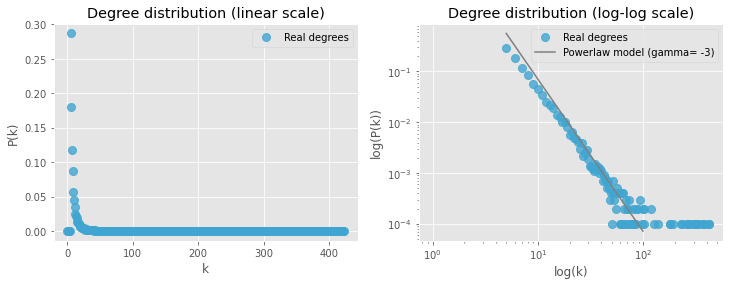

In [50]:
plt.figure(figsize=(12,4))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plot_distrib_lin(graph=G, colour='#40a6d1', alpha=.8)
plt.subplot(1, 2, 2)
plot_distrib_log(graph=G, colour='#40a6d1', alpha=.8, fit_line=True, expct_lo=5, expct_hi=100, expct_const=70)

plt.show()

### Degree distribution histograms

In [15]:
# Auxiliary function to create logaritmically spaced bins (for log-log histogram) by specifying the number of bins
def create_log_bins(degrees, num = 20):
    bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), num)
    bins = np.array(bins)
    return bins

In [16]:
# PDF histogram in linear scale
def plot_linear_PDF(G, name='', nbins = 15):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('PDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = False)
    plt.tight_layout()
    plt.style.use('ggplot')
        
#plot_linear_PDF(G)

In [17]:
# PDF histogram in Log-Log scale
def plot_loglog_PDF(G, name="", nbins=20):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num = nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('PDF in log-log scale',  fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = False)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_loglog_PDF(G)

In [18]:
# CCDF histogram in linear scale
def plot_linear_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_linear_CCDF(G)

In [19]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in log-log scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')
    
#plot_loglog_CCDF(G)

In [20]:
# number of bins to use
n_bins = 15

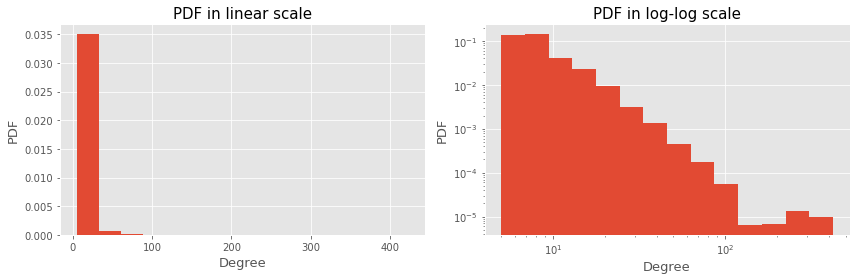

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_PDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_PDF(G, nbins=n_bins)
plt.show()

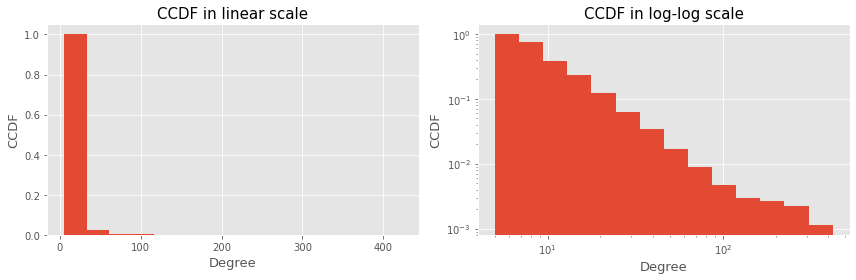

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_CCDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_CCDF(G, nbins=n_bins)
plt.show()

## Estimation of the exponent for the empirical degree distributions of BA and CM(SF), for the networks of size N>=1000.
We'll see 3 main approaches for estimating the exponent of a scale-free network:
* MLE
* Linear regression on the binned PDF histogram
* Linear regression on the binned CCDF histogram

Let's see these three approaches and then we'll compare the results obtained by each one of them

### Using MLE
* We can use the <i>powerlaw</i> Python package described here: https://arxiv.org/abs/1305.0215, which is based on a MLE of the exponent of a powerlaw distribution . <br>
As described in the paper https://arxiv.org/abs/0706.1062, the <i>powerlaw</i> package we use performs the exponent estimation by following the formula 3.7 <br>
According to the paper, the first step to perform a maximum likelihood fit to a powerlaw is to determine what portion of the data to fit. A heavy-tailed
distribution's interesting feature is, indeed, the tail and its properties, so if the initial, small values of the data
do not follow a power law distribution we may opt to disregard them. The question is from what
minimal value xmin (Kmin) the scaling relationship of the power law begins. The methods descibed in the paper of Clauset et al. mentioned above find this optimal value of xmin by creating a powerlaw fit starting from each unique value in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance, D, between the data and the fit. Therefore the algorithm finds xmin my minimizing D. <br> <br>
* While the maximum likelihood fit to a continous power law can be calculated analytically,
and thus the optimal xmin and resulting fitted parameters can be computed quickly, this is not so for the discrete case. The maximum likelihood fit for a discrete power law is found by numerical optimization,
the computation of which for every possible value of xmin can take time. To circumvent this issue,
powerlaw can use an analytic estimate of gamma, from [https://arxiv.org/abs/0706.1062], which can "give results accurate to about 1% or
better provided xmin ≥ 6".




In [23]:
#pip install powerlaw
#pip install mpmath 

In [24]:
import powerlaw

degrees = [G.degree(n) for n in G.nodes()]
results = powerlaw.Fit(degrees, discrete = True)
print("\n\nExponent estimation:")
print(round(results.power_law.alpha, 4))
#print(results.power_law.xmin)

Calculating best minimal value for power law fit
xmin progress: 99%

Exponent estimation:
2.793


### Using Linear Regression

In [25]:
# find min and max of the degrees
Kmin = np.min(degrees)
Kmax = np.max(degrees)

Kmin, Kmax

(5, 423)

In [26]:
# calculate the logarithm of K_i for all the data elements
log_degrees = [np.log10(G.degree(n)) for n in G.nodes()]
#log_degrees

In [27]:
# calculate useful logs
log_Kmin = np.log10(Kmin)
#log_Kmax = np.log10(Kmax)
log_Kmax_1 = np.log10(Kmax + 1)
log_Kmin, log_Kmax_1

(0.6989700043360189, 2.6273658565927325)

Divide the interval in equal size bins and build the bind

In [28]:
# length of the interval
interval_length = (log_Kmax_1 - log_Kmin) / n_bins

# build the bins
bins = []
for i in range(n_bins):
    bins.append(log_Kmin + interval_length * i)
bins.append(log_Kmax_1)
bins

[0.6989700043360189,
 0.8275297278197997,
 0.9560894513035807,
 1.0846491747873617,
 1.2132088982711426,
 1.3417686217549236,
 1.4703283452387044,
 1.5988880687224851,
 1.727447792206266,
 1.856007515690047,
 1.984567239173828,
 2.113126962657609,
 2.24168668614139,
 2.370246409625171,
 2.4988061331089515,
 2.6273658565927325]

In [29]:
# Count how many elements ki have their log(ki) in each bin
counts = []
for i in range(n_bins):
    counts.append(len([deg for deg in log_degrees if deg >= bins[i] and deg < bins[i+1]]))

counts

[4670, 2621, 1044, 677, 406, 282, 132, 81, 37, 20, 9, 1, 5, 7, 8]

In [30]:
# Dividing the number of elements in each bin by the total number of elements n we get estimations for the probabilities p_b of each bin
probs = [deg/ N for deg in counts]
probs # probabilities of each bin

[0.467,
 0.2621,
 0.1044,
 0.0677,
 0.0406,
 0.0282,
 0.0132,
 0.0081,
 0.0037,
 0.002,
 0.0009,
 0.0001,
 0.0005,
 0.0007,
 0.0008]

In [31]:
np.sum(probs)

1.0

### Linear regression on the PDF

We now need to make the linear regression of pairs (x_b, log_pb) to obtain the regression line. <br>
Let's first calculate the elements of log_pb


In [32]:
log_PDF_p = [np.log10(p) for p in probs]
log_PDF_p

[-0.33068311943388784,
 -0.5815329790533995,
 -0.9812995013337567,
 -1.1694113313148558,
 -1.391473966422806,
 -1.5497508916806388,
 -1.8794260687941502,
 -2.0915149811213505,
 -2.431798275933005,
 -2.6989700043360187,
 -3.0457574905606752,
 -4.0,
 -3.3010299956639813,
 -3.154901959985743,
 -3.0969100130080562]

We may have some infinite values: let's remove them from the list

In [33]:
# list containing indices of the infinite elements
inf_indices = []

# populate the list
for i in range(len(log_PDF_p)):
    if math.isinf(log_PDF_p[i]):
        inf_indices.append(i)
               
inf_indices

[]

In [34]:
# select only finite elements:
log_PDF_p = [v for v in log_PDF_p if not math.isinf(v)]
log_PDF_p

[-0.33068311943388784,
 -0.5815329790533995,
 -0.9812995013337567,
 -1.1694113313148558,
 -1.391473966422806,
 -1.5497508916806388,
 -1.8794260687941502,
 -2.0915149811213505,
 -2.431798275933005,
 -2.6989700043360187,
 -3.0457574905606752,
 -4.0,
 -3.3010299956639813,
 -3.154901959985743,
 -3.0969100130080562]

The X vector of the linear regression is the bins vector, except from the first element <br>

In [35]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.8275297278197997,
 0.9560894513035807,
 1.0846491747873617,
 1.2132088982711426,
 1.3417686217549236,
 1.4703283452387044,
 1.5988880687224851,
 1.727447792206266,
 1.856007515690047,
 1.984567239173828,
 2.113126962657609,
 2.24168668614139,
 2.370246409625171,
 2.4988061331089515,
 2.6273658565927325]

The Y vector of the linear regression is log_PDF_pLog_pb

In [36]:
Y = log_PDF_p
Y

[-0.33068311943388784,
 -0.5815329790533995,
 -0.9812995013337567,
 -1.1694113313148558,
 -1.391473966422806,
 -1.5497508916806388,
 -1.8794260687941502,
 -2.0915149811213505,
 -2.431798275933005,
 -2.6989700043360187,
 -3.0457574905606752,
 -4.0,
 -3.3010299956639813,
 -3.154901959985743,
 -3.0969100130080562]

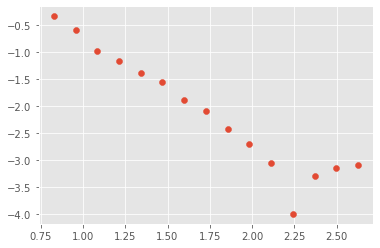

In [37]:
plt.scatter(X, Y)
plt.show()

Let's perform the Linear Regression by using the stats function of the scipy package

In [38]:
regr = stats.linregress(X, Y)

We are interested in the slope of the regression line, indeed the estimation of the exponent is: <br>
* gamma = -slope + 1

In [39]:
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.8206788174807353

Exponent estimation: 2.8206788174807356


### Linear regression on the CCDF

Another alternative for the estimation of exponent gamma consists in doing exactly the same as above but for the complementary cumulative distribution function (CCDF) instead of the probability density function (PDF). <br>
CCDF is calculated from the PDF just by summing up 
the probabilities of all the bins to the right of the bin you are considering (this one included in the sum). 

In [40]:
# probabilities of the bins
probs

[0.467,
 0.2621,
 0.1044,
 0.0677,
 0.0406,
 0.0282,
 0.0132,
 0.0081,
 0.0037,
 0.002,
 0.0009,
 0.0001,
 0.0005,
 0.0007,
 0.0008]

In [41]:
# compute CCDF by summing on the right
CCDF_c = []
for i in range(len(probs)):
    CCDF_c.append(np.sum(probs[i:]))

In [42]:
CCDF_c

[1.0,
 0.533,
 0.27090000000000003,
 0.16649999999999998,
 0.0988,
 0.0582,
 0.03,
 0.0168,
 0.0087,
 0.005,
 0.003,
 0.0021,
 0.002,
 0.0015,
 0.0008]

We now need to make the linear regression of pairs (x_b and log_pb) to obtain the regression line.<br>
Let's first calculate the elements of log(cb)

In [43]:
log_CCDF_c = [np.log10(c) for c in CCDF_c]
log_CCDF_c

[0.0,
 -0.2732727909734277,
 -0.5671909949668317,
 -0.7785857621576614,
 -1.005243055412372,
 -1.2350770153501116,
 -1.5228787452803376,
 -1.7746907182741372,
 -2.0604807473813813,
 -2.3010299956639813,
 -2.5228787452803374,
 -2.677780705266081,
 -2.6989700043360187,
 -2.8239087409443187,
 -3.0969100130080562]

Again, as before, we may have infinite values that we should remove

In [44]:
# list containing indices of the infinite elements
inf_indices = []

for i in range(len(log_CCDF_c)):
    if math.isinf(log_CCDF_c[i]):
        inf_indices.append(i)
               
inf_indices

[]

In [45]:
# select only finite elements:
log_CCDF_c = [v for v in log_CCDF_c if not math.isinf(v)]
log_CCDF_c

[0.0,
 -0.2732727909734277,
 -0.5671909949668317,
 -0.7785857621576614,
 -1.005243055412372,
 -1.2350770153501116,
 -1.5228787452803376,
 -1.7746907182741372,
 -2.0604807473813813,
 -2.3010299956639813,
 -2.5228787452803374,
 -2.677780705266081,
 -2.6989700043360187,
 -2.8239087409443187,
 -3.0969100130080562]

X vector is the bins vector, except from the first element <br>

In [46]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.8275297278197997,
 0.9560894513035807,
 1.0846491747873617,
 1.2132088982711426,
 1.3417686217549236,
 1.4703283452387044,
 1.5988880687224851,
 1.727447792206266,
 1.856007515690047,
 1.984567239173828,
 2.113126962657609,
 2.24168668614139,
 2.370246409625171,
 2.4988061331089515,
 2.6273658565927325]

Y vector is the log_CCDF_c vector computed above

In [47]:
Y = log_CCDF_c

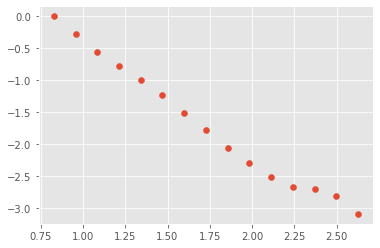

In [48]:
plt.scatter(X, Y)
plt.show()

Let's perform the Linear Regression by using the stats function of the scipy package: the procedure is the same as before.

In [49]:
regr = stats.linregress(X, Y)
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.7351656254693957

Exponent estimation: 2.7351656254693957


#### Conclusion on exponent estimation
Binning-based approaches, i.e. the 2 approaches we saw based on constructing bins and performing regression on the binned data,  perform poorly. <br>
As we can easily imagine, in binning-based approaches the estimated exponent is highly dependent on the choice of bin width, and this dependency varies as a function of sample size ( [https://esajournals.onlinelibrary.wiley.com/doi/10.1890/07-1288.1White]). <br>
In general, binning results in a loss of
information about the distributions of points within a
bin and is thus expected to perform poorly (Clauset et al.
2007, Edwards et al. 2007). Therefore, while binning is
useful for visualizing the frequency distribution, and
normalized logarithmic binning performs well at this
task, binning-based approaches should be avoided for
parameter estimation (Clauset et al. 2007). <br>

Maximum likelihood estimation performs best in estimating the powerlaw exponent.